# 1. Load package and Read data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import (accuracy_score, classification_report)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb

#### Note. The dataset used for the demonstration is from https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset 

#### Note. The data exploration of the current dataset can go to the following kernal on Kaggle 

https://www.kaggle.com/arthurtok/employee-attrition-via-ensemble-tree-based-methods

In [2]:
attrition = pd.read_csv('C:/Users/blah/Documents/pythone_dataset/IBM_hr_attrition.csv', sep = '\t')

# 2. Data cleaning and preparing 

## Categorical encoding

In [4]:
# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

## Dummy code the categorical predictor

In [5]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = attrition[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column

attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)

BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
0                          0                                 0   
1                          0                                 1   
2                          0                                 0   

   BusinessTravel_Travel_Rarely  Department_Human Resources  \
0                             1                           0   
1                             0                           0   
2                             1                           0   

   Department_Research & Development  Department_Sales  \
0                                  0                 1   
1                                  1                 0   
2                                  1                 0   

   EducationField_Human Resources  EducationField_Life Sciences  \
0                               0                             1   
1                               0                             1   
2                               0                             0   

   EducationField_Marketing  EducationField_Medical  ...  \
0                         0                       0  ...   
1                         0                       0  ...   
2                         0                       0  ...   

   JobRole_Research Director  JobRole_Research Scientist  \
0                          0                           0   
1                          0                           1   
2                          0                           0   

   JobRole_Sales Executive  JobRole_Sales Representative  \
0                        1                             0   
1                        0                             0   
2                        0                             0   

   MaritalStatus_Divorced  MaritalStatus_Married  MaritalStatus_Single  \
0                       0                      0                     1   
1                       0                      1                     0   
2                       0                      0                     1   

   Over18_Y  OverTime_No  OverTime_Yes  
0         1            0             1  
1         1            1             0  
2         1            0             1  

[3 rows x 29 columns]

## Creating new features from Numerical data and standardize it

In [6]:
# Store the numerical features to a dataframe attrition_num
attrition_num = attrition[numerical]

columns = attrition_num.columns

x = attrition_num.values #returns a numpy array
x_scaled = preprocessing.scale(x)
attrition_num = pd.DataFrame(x_scaled, columns = columns)

C:\Users\blah\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Concat numerical and categorical data togeter

In [7]:
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)

## Dummy code outcome value

In [8]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])
target.head(3)

0    1
1    0
2    1
Name: Attrition, dtype: int64

In [9]:
X=attrition_final.as_matrix()
y=target.as_matrix()

C:\Users\blah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\blah\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# 4. Split train test data

In [10]:
from sklearn.model_selection import train_test_split




# Split data into train and test sets as well as for validation and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size= 0.80,
                                                    random_state=100,
                                                    stratify = target)


C:\Users\blah\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Given the target data is highly skewed (more than 90% of the outcomes are stay), we use the SMOTE method to oversample the data.

In [11]:
oversampler=SMOTE(random_state=101)
smote_train, smote_target = oversampler.fit_sample(X_train,y_train)



## 5. Fitting XGB Classifier to the train data



## Define estimator and param_grid 

In [12]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)

# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 1000],
        'learning_rate' : [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 7],
        'gamma': [0.1, 0.5, 1],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5, 12]
        }



## Hyper parameter tuning with randomsearch

In [13]:
from sklearn.model_selection import RandomizedSearchCV


random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=10, scoring='roc_auc', n_jobs=3, cv=10, verbose=3, random_state=101)

random_search.fit(smote_train, smote_target)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   20.4s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=3,
          param_distributions={'n_estimators': [100, 200, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'min_child_weight': [1, 5, 7], 'gamma': [0.1, 0.5, 1], 'subsample': [0.6, 1.0], 'colsample_bytree': [0.6, 1.0], 'max_depth': [3, 5, 12]},
          pre_dispatch='2*n_jobs', random_state=101, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

## Training result

In [14]:
print('\n XGB: Best roc-auc for %d-fold search with %d parameter combinations:' % (10, 100))
print(random_search.best_score_ )

print('\n XGB: Best hyperparameters:')
print(random_search.best_params_)




 XGB: Best roc-auc for 10-fold search with 100 parameter combinations:
0.978906714200832

 XGB: Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.6}


## Fitting xgb model and to the test data and get performance report

In [15]:
# xgb 
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.01,
                           colsample_bytree=0.6, gamma=0.5, learning_rate=0.05,
                           max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
                           n_estimators=500, n_job=-1, nthread=None,
                           objective='binary:logistic', random_state=0, reg_alpha=0,
                           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.6)

xgb_clf.fit(smote_train, smote_target)
y_pred_x = xgb_clf.predict(X_test)

In [16]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_x)))
print("="*80)
print(classification_report(y_test, y_pred_x))


Accuracy score: 0.9047619047619048
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       247
           1       0.81      0.53      0.64        47

   micro avg       0.90      0.90      0.90       294
   macro avg       0.86      0.75      0.79       294
weighted avg       0.90      0.90      0.90       294



# 6. Fitting Logistic regression model to the train data and apply the logistic regression model to the test data

In [17]:
logreg = LogisticRegression()

logreg.fit(smote_train, smote_target)
y_pred_l = logreg.predict(X_test)

C:\Users\blah\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Scoring the model: Logistic Regression 

In [18]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred_l)))
print("="*80)
print(classification_report(y_test, y_pred_l))


Accuracy score: 0.7244897959183674
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       247
           1       0.34      0.79      0.48        47

   micro avg       0.72      0.72      0.72       294
   macro avg       0.64      0.75      0.65       294
weighted avg       0.85      0.72      0.76       294



# 7. Models comparison

## Roc auc plot

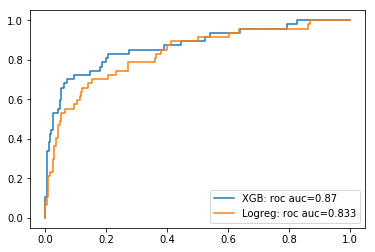

In [19]:
from sklearn import metrics

#create curve for XGB
y_pred_proba_x = xgb_clf.predict_proba(X_test)[::,1]
fpr_x, tpr_x, _ = metrics.roc_curve(y_test,  y_pred_proba_x)
auc_x = metrics.roc_auc_score(y_test, y_pred_proba_x)

#create curve for Logreg
y_pred_proba_l = logreg.predict_proba(X_test)[::,1]
fpr_l, tpr_l, _ = metrics.roc_curve(y_test,  y_pred_proba_l)
auc_l = metrics.roc_auc_score(y_test, y_pred_proba_l)

#AUC for XGB 
auc_x = round(auc_x, 3)
#AUC for Logreg
auc_l = round(auc_l, 3)



plt.plot(fpr_x,tpr_x,label="XGB: roc auc="+str(auc_x))
plt.plot(fpr_l,tpr_l,label="Logreg: roc auc="+str(auc_l))
plt.legend()
plt.show()

## Recall precision curve

XGB: f1=0.641 auc=0.695 ap=0.698
Logreg: f1=0.477 auc=0.569 ap=0.575


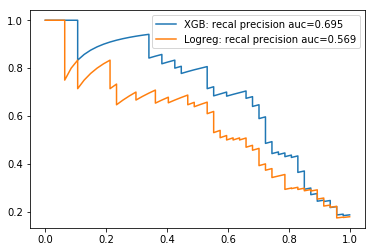

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

##create curve for XGB

# predict probabilities
probs_x = xgb_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_x = probs_x[:, 1]
# predict class values
yhat_x = xgb_clf.predict(X_test)
# calculate precision-recall curve
precision_x, recall_x, thresholds_x = precision_recall_curve(y_test, probs_x)
# calculate F1 score
f1_x = f1_score(y_test, yhat_x)
# calculate precision-recall AUC
auc_x = auc(recall_x, precision_x)
# calculate average precision score
ap_x = average_precision_score(y_test, probs_x)


##create curve for Logreg

# predict probabilities
probs_l = logreg.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs_l = probs_l[:, 1]
# predict class values
yhat_l = logreg.predict(X_test)
# calculate precision-recall curve
precision_l, recall_l, thresholds_l = precision_recall_curve(y_test, probs_l)
# calculate F1 score
f1_l = f1_score(y_test, yhat_l)
# calculate precision-recall AUC
auc_l = auc(recall_l, precision_l)
# calculate average precision score
ap_l = average_precision_score(y_test, probs_l)





print('XGB: f1=%.3f auc=%.3f ap=%.3f' % (f1_x, auc_x, ap_x))

print('Logreg: f1=%.3f auc=%.3f ap=%.3f' % (f1_l, auc_l, ap_l))


auc_x = round(auc_x, 3)
auc_l = round(auc_l, 3)

# plot the precision-recall curve for the model
plt.plot(recall_x, precision_x,label="XGB: recal precision auc="+str(auc_x))
plt.plot(recall_l, precision_l,label="Logreg: recal precision auc="+str(auc_l))

# show the plot
plt.legend()
plt.show()

#### Note. Given the sample is highly skewed, ROC AUC is not a reilable matric for model comparison in this situation. The recall and precision curve is a better matric to evaluete the model performance in the current task. We can see the XGB model outperform the linear regression model for both matrics. We will go ahead and use the the SHAP package to interpre the XGB model.

# 7. Interpret XGB model with Shap

In [21]:
import shap

# load JS visualization code to notebook
shap.initjs()


# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(attrition_final)


## visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)

In [22]:

shap.force_plot(explainer.expected_value, shap_values[0,:], attrition_final.iloc[4,:])

#### Note. The base value suggest when no predictors invovle, the model have a bias output as 0.01927(log odd). 


#### Note. From the first case, we can see the model identify the overtime_no = 1 and the overtime_yes=0 as the strongest drivers to drive the prediction toward turnover; on the other hand, the model also identify job satisfaction and Distance from home as the strongest drivers to drive the prediction toward stay. 

#### Note. The final prediction of this case is -1.01(log odd). Predicting this case will stay. 


## visualize the training set predictions with the force plot

In [23]:
shap.force_plot(explainer.expected_value, shap_values, attrition_final)

#### Note. The force plot flip all the Shapley value from the plot above vertically and map them in the same plot. 

#### Note. The SHAP value is indicate on the Y axis and the number of cases are indicates on the X axis. 

#### Note. We can view this force plot with similarity among cases, output value and other different views by toggling the bar on the top of the plot


## visualize the SHAP value with the summary plot

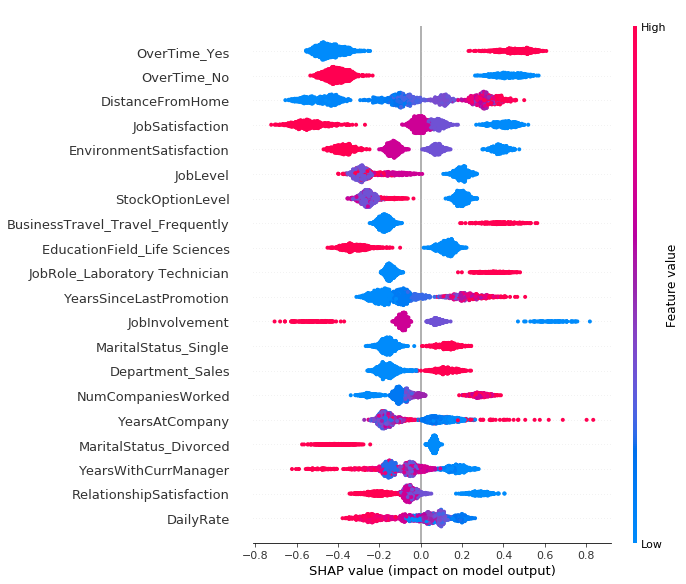

In [24]:
shap.summary_plot(shap_values, attrition_final)

#### Note. In this summary plot, the SHAP value and the feature value of every case represent a dot in the plot and all the cases are plot in each of the predictors. 

#### Note. The Feature value is represented with color spectrum and the SHAP value is represented with the placement of the dot for every case. 

#### Note. This summary plot provide summary information on how the feature value related to the SHAP value in the model. 

#### Note. For example, for the dichotomized variable OverTime_Yes , when it is one, it is more likely to have a positive SHAP value and when it is zero, it is more likely to have negative SHAP value. 

#### Note. For example, for the continuous variable DistanceFromHome, the SHAP value increase as the variable increase. 

## visualize the absolute SHAP value summary plot to evaluate feature importance to the model

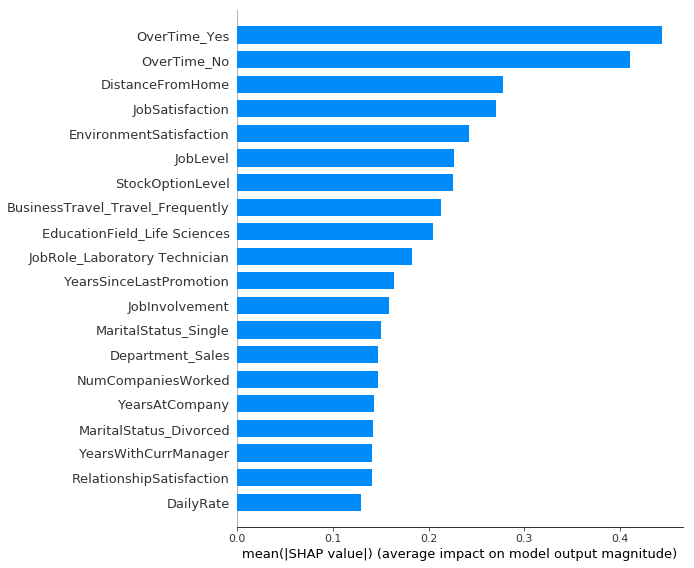

In [54]:
shap.summary_plot(shap_values, attrition_final, plot_type="bar")

#### Note. In this plot, we take the absoulate value of the SHAP value and then sum it up variable by variable. 

#### Note. We can access the predictor importance to the model with this plot

# Visualize dependent plot by variable 

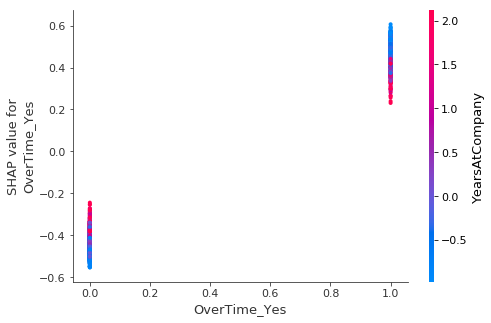

In [56]:
shap.dependence_plot("OverTime_Yes", shap_values, attrition_final)

#### Note. We first create dependent plot for OverTime_yes

#### Note. Each dot in this plot represent the SHAP value for OverTime_yes for one case. 

#### Note. The color spectrum represent the feature value of another feature (we normalized the YearAtCompany variable before we build the model). 

#### Note. The selection of another feature is based on correlations of the SHAP value of OverTime_yes and the SHAP value of the rest of feature. The algorithum will select the feature that have the stronggest correlation with the variable being ploted. The stong correlation between the SHAP values of two variables suggest these two model are likely to interact with each other inside the model.  

#### Note. From this dependent plot, we can see the YearAtCompany virable might interact with the OverTime_yes variable in a way that the longer the employees stay in the company, the lesser impact the variable Overtime_yes have on the turnover decision of the employees. (The range of the SHAP value is smaller for those cases have a larger feature value of YearsAtcompany.)


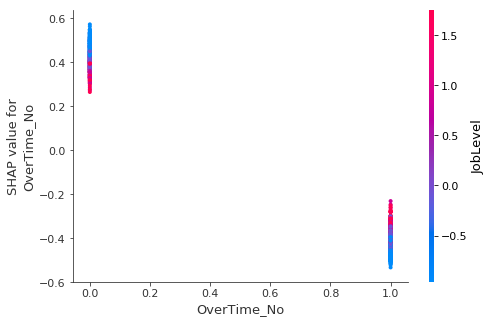

In [57]:
shap.dependence_plot("OverTime_No", shap_values, attrition_final)

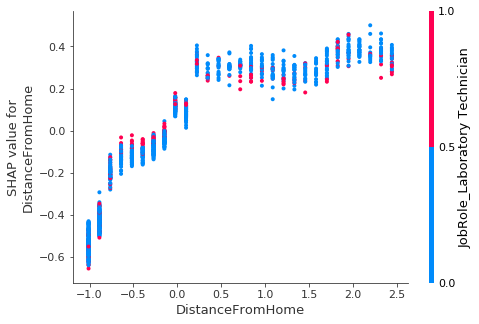

In [58]:
shap.dependence_plot("DistanceFromHome", shap_values, attrition_final)

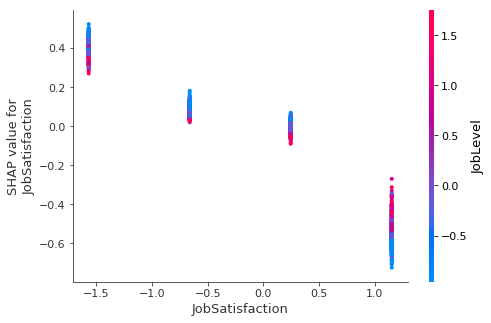

In [60]:
shap.dependence_plot("JobSatisfaction", shap_values, attrition_final)

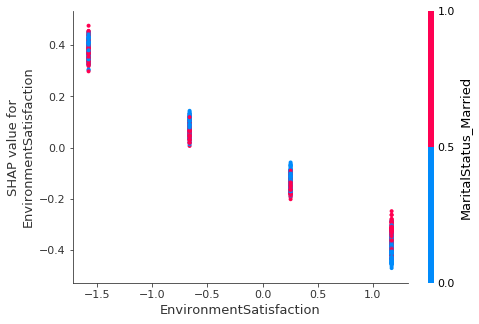

In [63]:
shap.dependence_plot("EnvironmentSatisfaction", shap_values, attrition_final)

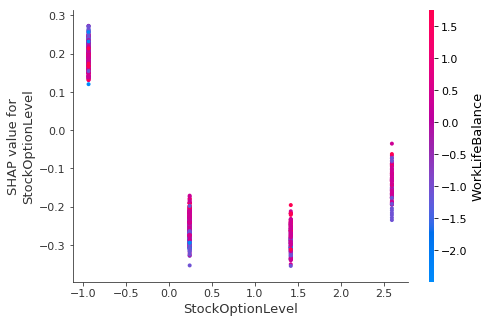

In [61]:
shap.dependence_plot("StockOptionLevel", shap_values, attrition_final)